In [1]:
%matplotlib widget
# %matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.optimize import curve_fit


from qick import *
from qick.helpers import gauss

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq
import Pyro4.util

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})
mpl.rcParams['figure.dpi'] = 150

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyle_cycle=['solid', 'dashed', 'dotted', 'dashdot']
marker_cycle = ['o', '*', 's', '^']

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


# Load experiments

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

### Set save data

In [4]:
save_data = False

In [5]:
def prev_data(expt_path, filename=None):
    """Reopen saved data"""
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [6]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
expt_path = os.path.join(data_path, 'data', 'data_241025')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_241025


In [7]:
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


# Load config

In [43]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [9]:
im = InstrumentManager(ns_address='10.108.30.75') # Spilker Fermium
print(list(im))

['Pyro.NameServer', 'Qick_QRAM']


In [10]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Sat Oct  5 10:21:47 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

## Parameter

In [11]:
qubit_i = 1

# Rabi versus amplitude 

We first want to know the relationship between the gain and rabi drive strength

In [176]:
gain_start = 100 
gain_stop = 1000
gain_pts = 5
gain_vec = np.linspace(gain_start, gain_stop, gain_pts)

reps = 1
rounds = 100 

t_start = 0.1
t_stop = 0.5 # us
t_pts = 300
t_step = (t_stop - t_start) / t_pts
print(f'Time step is {t_step} us')
t_step = soc.cycles2us(soc.us2cycles(t_step))
print(f'Time step is {t_step} cycles')

rabi_freq_vec = np.zeros(gain_pts)
rabi_freq_vec_err = np.zeros(gain_pts)

save_data = True

Time step is 0.0013333333333333335 us
Time step is 0.0023251488095238095 cycles


In [177]:

RabiFreqExpt = Experiment(
                        path=expt_path,
                        prefix=f"rabi_freq_{qubit_i}",
                        config_file=config_path)

RabiFreqExpt.data = dict(amps=[], times=[], rabi_freq = [], gain_pts=[])
RabiFreqExpt.data['gain_pts'] = gain_vec

time_vec = []
amps_vec = []


for idx_g, g in enumerate(gain_vec):
    print(f"Gain {g} ({idx_g+1}/{len(gain_vec)})")

    lengthrabi = meas.LengthRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"length_rabi_qubit{qubit_i}",
        config_file=config_path,
    )
    lengthrabi.cfg = AttrDict(deepcopy(yaml_cfg))
    
    lengthrabi.cfg.device.qubit.pulses.pi_ge.half_gain[qubit_i*5] = int(g)

    lengthrabi.cfg.expt = dict(
        start=t_start, # pulse length (sigma) [us]
        step=t_step, # [us]
        expts=t_pts,
        reps=reps*rounds,
        pulse_type='gauss',
        checkEF=False, 
        qTest=qubit_i,
        qZZ=None,
    )

    import Pyro4.util
    try:
        lengthrabi.go(analyze=False, display=False, progress=True, save=False)
        
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
        

    amps = lengthrabi.data['amps']
    time = lengthrabi.data['xpts']
    # compute FFT
    amp_fft = fft(amps)
    freq = fftfreq(len(amps), time[1] - time[0])
    
    # find the peak
    idx = np.argmax(np.abs(amp_fft[1:])) + 1
    freq_peak = freq[idx]
    

    rabi_freq_vec[idx_g] = freq_peak/2

    
    if save_data:
        time_vec.append(time)
        amps_vec.append(amps)
        
        
    


Gain 100.0 (1/5)
Running length rabi on Q1 


  0%|          | 0/300 [00:00<?, ?it/s]

Gain 325.0 (2/5)
Running length rabi on Q1 


  0%|          | 0/300 [00:00<?, ?it/s]

Gain 550.0 (3/5)
Running length rabi on Q1 


  0%|          | 0/300 [00:00<?, ?it/s]

Gain 775.0 (4/5)
Running length rabi on Q1 


  0%|          | 0/300 [00:00<?, ?it/s]

Gain 1000.0 (5/5)
Running length rabi on Q1 


  0%|          | 0/300 [00:00<?, ?it/s]

In [178]:
# fit with a linear function

def linear(x, a, b):
    return a*x + b

popt, pcov = curve_fit(linear, gain_vec, rabi_freq_vec)

a = popt[0]
a_err = np.sqrt(pcov[0,0])
b = popt[1]
b_err = np.sqrt(pcov[1,1])


if save_data:
    RabiFreqExpt.data['times'] = time_vec
    RabiFreqExpt.data['amps'] = amps_vec
    # divide by 2 to get the Rabi frequency ( given we apply two pi/2 actually)
    RabiFreqExpt.data['rabi_freq'] = rabi_freq_vec
    RabiFreqExpt.data['fit'] = [a, b]
    RabiFreqExpt.data['fit_err'] = [a_err, b_err]
    RabiFreqExpt.save_data()

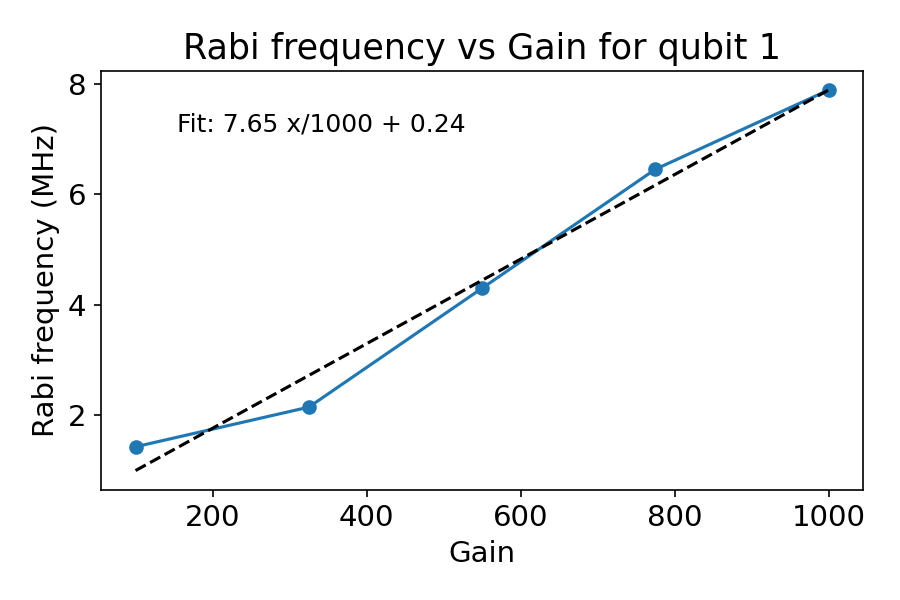

In [179]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(gain_vec, rabi_freq_vec, 'o-')
ax.plot(gain_vec, linear(gain_vec, *popt), '--', color='black')

text = f"Fit: {a*1000:.2f} x/1000 + {b:.2f}\n"
ax.text(0.1, 0.9, text, transform=ax.transAxes, fontsize=12, verticalalignment='top')

ax.set_xlabel('Gain')
ax.set_ylabel('Rabi frequency (MHz)')
ax.set_title(f'Rabi frequency vs Gain for qubit {qubit_i}')
fig.tight_layout()

In [180]:
filename = yaml_cfg.device.qubit.pulses.pihalf_ge_robust.filename[qubit_i]
path = os.path.join('S:\QRAM\qram_4QR2\optctrl_pulses', f"{filename}.npz")
nb_qb = 4


# open the file
scaling = 1

with np.load(path) as data:
    times = data['times']*scaling
    I = []
    Q = []
    for i in range(nb_qb):
        if 'I_'+str(i) in data:
            I.append(data['I_'+str(i)]/1e6/scaling)
            Q.append(data['Q_'+str(i)]/1e6/scaling)
        else:
            I.append(np.zeros(times.shape))
            Q.append(np.zeros(times.shape))

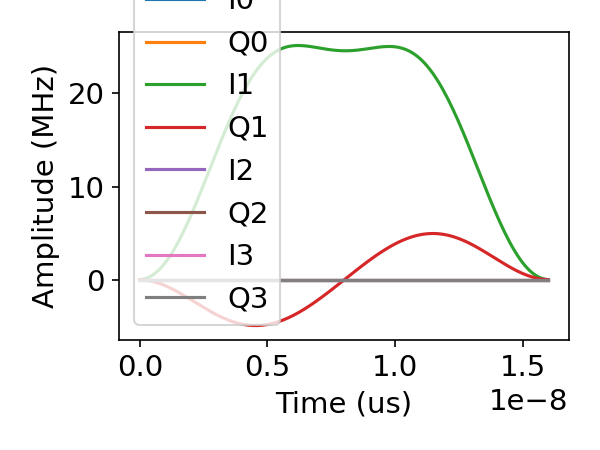

In [181]:
fig, ax = plt.subplots(figsize=(4,3))

for i in range(len(I)):
    ax.plot(times, I[i], label=f'I{i}')
    ax.plot(times, Q[i], label=f'Q{i}')
    
ax.set_xlabel('Time (us)')
ax.set_ylabel('Amplitude (MHz)')

ax.legend()
fig.tight_layout()
    

In [182]:
# for all qubit take the maximum of the I and Q

gain = np.zeros(len(I), dtype=int)

for i in range(len(I)):
    amp_I = np.max(np.abs(I[i]))
    amp_Q = np.max(np.abs(Q[i]))
    amp_max = np.max([amp_I, amp_Q])
    if amp_max == 0:
        gain[i] = 0
    else:
        gain_max = (amp_max - b) / a
        # for some reason the gain we need to set is twice the value
        gain[i] = gain_max*2
        
        

In [183]:
gain

array([   0, 6515,    0,    0])

# First round of error amplification to get the gain right

In [184]:
gain_scale = np.linspace(0.7, 1.3, 11)

x_tab = []
p_tab = []

# qubit_i=0
# gain = [7580, 0, 0, 0]


for s in gain_scale:

    npulsecalib = meas.NPulseExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"NPulseExptQ{qubit_i}",
        config_file=config_path,
    )

    npulsecalib.cfg = AttrDict(deepcopy(yaml_cfg))
    npulsecalib.cfg.device.qubit.pulses.pihalf_ge_robust[f"gain_q{qubit_i}"][qubit_i] = gain[qubit_i]*s

    npulsecalib.cfg.expt = dict(
        start=3, # number gate repetitions
        step=10,
        expts=1,
        reps=100,
        loops=10,
        pulse_type='robust',
        checkEF=False, 
        qTest=qubit_i,
        qZZ=None,
        test_pi_half=True,
        error_amp=True,
        skip_first_pi2=True,
        post_process='scale',
        singleshot_reps=5000,
    )

    # print(npulsecalib.cfg)
    import Pyro4.util
    try:
        npulsecalib.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
        
        
    data = npulsecalib.data
    
    p_vec = data['avgi'][-1]
    x_vec = data['xpts'][-1]
    
    p_tab.append(p_vec)
    x_tab.append(x_vec)

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 59.62 	 angle (deg): -141.45228279020458 	 threshold ge: 289.64111747611366


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 62.980000000000004 	 angle (deg): -142.36499679231463 	 threshold ge: 291.9381287613039


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 60.28 	 angle (deg): -142.09598921161728 	 threshold ge: 293.1934179477654


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 61.36000000000001 	 angle (deg): -142.17189912286514 	 threshold ge: 291.07294672400076


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 61.4 	 angle (deg): -142.7414939615927 	 threshold ge: 305.71461387563437


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 61.44614461446145 	 angle (deg): -143.0582882087979 	 threshold ge: 290.9063685250208


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 62.88 	 angle (deg): -141.81075630604255 	 threshold ge: 283.6726173195692


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 62.019999999999996 	 angle (deg): -144.963653252266 	 threshold ge: 260.8932145145914


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 58.28 	 angle (deg): -143.4258407819014 	 threshold ge: 293.04190494173054


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 63.22632263226322 	 angle (deg): -144.67831680828533 	 threshold ge: 273.9263912596191


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 60.06 	 angle (deg): -144.55767530893047 	 threshold ge: 271.86259036364737


  0%|          | 0/10 [00:00<?, ?it/s]

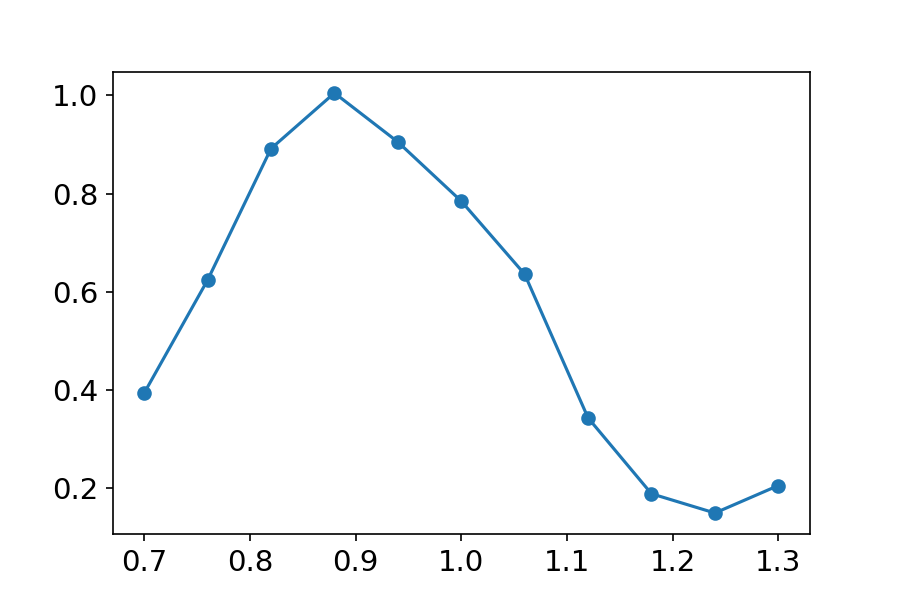

In [185]:
# fig, ax = plt.subplots(figsize=(6,4))   

# for i in range(len(p_tab)):
#     ax.plot(x_tab[i], p_tab[i], label=f'Gain {gain_scale[i]:.2f}')

# ax.set_xlabel('Number of pulses')
# ax.set_ylabel('Average intensity')
# ax.legend()

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(gain_scale, p_tab, 'o-')
    

In [186]:
gain_corr =  gain * 0.88
# save the new gain in the yaml file
yaml_cfg.device.qubit.pulses.pihalf_ge_robust[f"gain_q{qubit_i}"][qubit_i] = gain_corr[qubit_i]

# $\pi$-$\pi$ Exp

In [187]:
piminuspi = meas.PiMinusPiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"PiMinusPiExpt{qubit_i}",
    config_file=config_path,
)

span_f = 10
npts_f = 100

piminuspi.cfg = AttrDict(deepcopy(yaml_cfg))
# piminuspi.cfg.device.qubit.pulses.pihalf_ge_robust[f"gain_q{qubit_i}"][qubit_i] = gain_corr[qubit_i]

piminuspi.cfg.expt = dict(
    start_N=0, # number gate repetitions
    step_N=1,
    expts_N=10,
    start_f=piminuspi.cfg.device.qubit.f_ge_robust[qubit_i*4 + qubit_i]-span_f/2,
    step_f=span_f/npts_f,
    expts_f=npts_f+1,
    reps=int(0.75*reps*rounds),
    loops=1,
    pulse_type='robust',
    test_pi_half=True, 
    checkEF=False,
    qTest=qubit_i,
    qZZ=None,
    post_process='threshold',
    singleshot_reps=15000,
)

# print(piminuspi.cfg)
import Pyro4.util
try:
    piminuspi.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 61.94666666666667 	 angle (deg): -143.60950352479148 	 threshold ge: 265.5889550414371


  0%|          | 0/10 [00:00<?, ?it/s]

Fit best freq 3452.1080153228827 which is 3.9677590963392504 away from old freq 3448.1402562265434


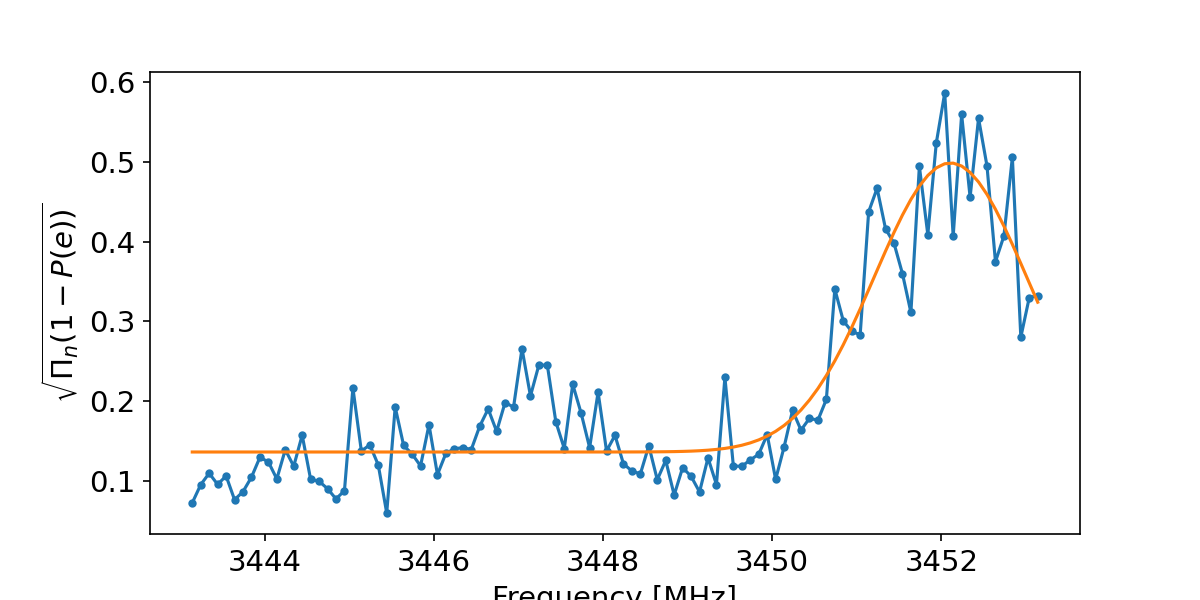

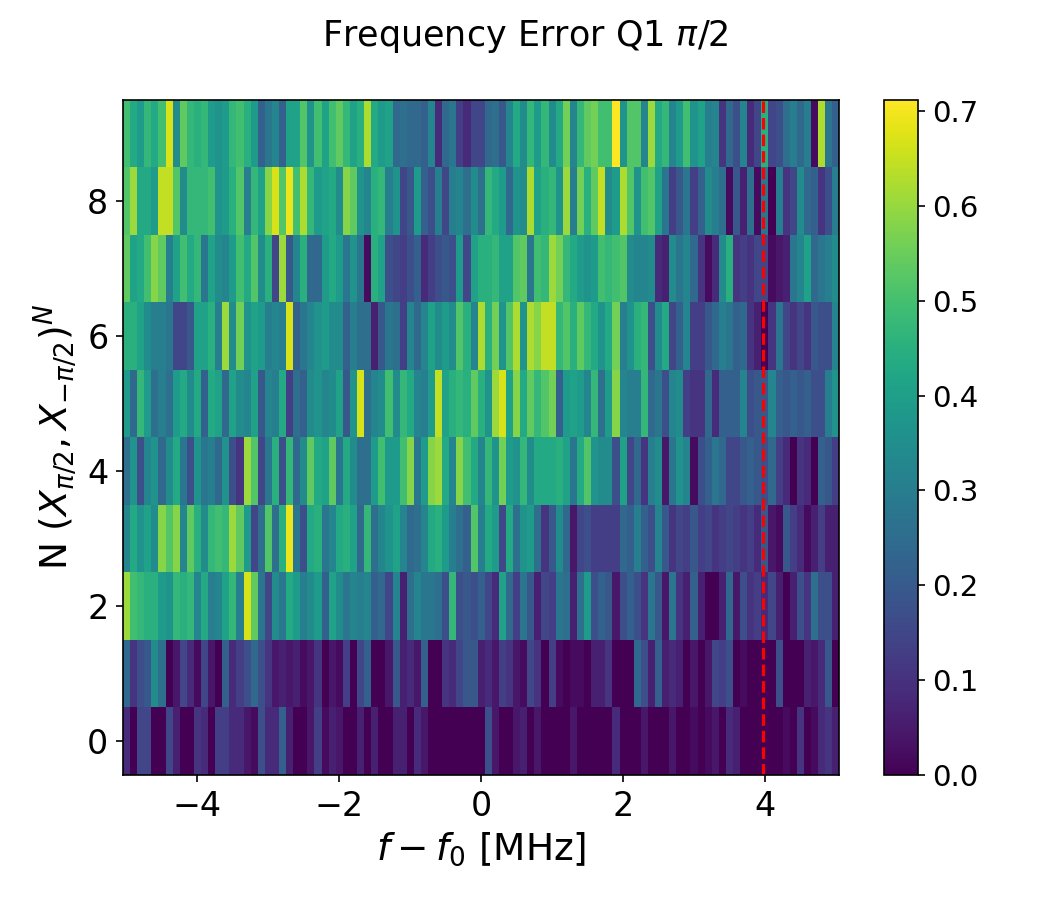

*New f_ge
 [[4114.49       4105.83890476 4110.9581533  4110.54640785]
 [3442.87557211 3452.10801532 3447.06031732 3446.49297928]
 [4762.76150413 4761.82356724 4763.94117763 4762.36981342]
 [4380.69860456 4379.60486812 4380.71783711 4384.25034226]]
*New f_ge flattened
[4114.49, 4105.838904759637, 4110.958153299016, 4110.546407850519, 3442.8755721075536, 3452.1080153228827, 3447.060317317807, 3446.4929792801067, 4762.761504132457, 4761.823567235975, 4763.941177625567, 4762.369813422167, 4380.698604555338, 4379.604868123916, 4380.717837106693, 4384.2503422597]


In [188]:
data = piminuspi.data
piminuspi.analyze(fit=True)
piminuspi.display(fit=True)

yaml_cfg.device.qubit.f_ge_robust = np.reshape(yaml_cfg.device.qubit.f_ge_robust, (4,4))
yaml_cfg.device.qubit.f_ge_robust[qubit_i, qubit_i] = data["best_freq"]
# results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
# print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i]}*')
# print(results_Qi)
print(f'*New f_ge\n', yaml_cfg.device.qubit.f_ge_robust)
yaml_cfg.device.qubit.f_ge_robust = yaml_cfg.device.qubit.f_ge_robust.flatten().tolist()
print(f'*New f_ge flattened\n{yaml_cfg.device.qubit.f_ge_robust}')



In [189]:
piminuspi.save_data()

Saving S:\QRAM\qram_4QR2\data\data_241025\00000_PiMinusPiExpt1.h5


'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00000_PiMinusPiExpt1.h5'

# Second round of error amplification

In [50]:
qubit_i = 0
gain = yaml_cfg.device.qubit.pulses.pihalf_ge_robust.gain[qubit_i*5]
print(f'New gain for qubit {qubit_i} is {gain}')

New gain for qubit 0 is 7553


In [52]:
npulsecalib = meas.NPulseExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"NPulseExptQ{qubit_i}",
        config_file=config_path,
    )


# 


npulsecalib.cfg = AttrDict(deepcopy(yaml_cfg))

# npulsecalib.cfg.device.qubit.pulses.pihalf_ge_robust[f"gain_q{qubit_i}"][qubit_i] = 5997.644279241582

npulsecalib.cfg.expt = dict(
    start=1, # number gate repetitions
    step=1,
    expts=10,
    reps=1000,
    loops=10,
    pulse_type='robust',
    checkEF=False, 
    qTest=qubit_i,
    qZZ=None,
    test_pi_half=True,
    error_amp=True,
    skip_first_pi2 = False, 
    post_process='threshold',
    singleshot_reps=5000,
    resonator_reset=True, 
    full_mux_expt = True,
)

# print(npulsecalib.cfg)
import Pyro4.util
try:
    npulsecalib.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/2 [00:00<?, ?it/s]

(3, 399999)
(3, 399999)
(399999,)
gain 6443.783333333334
ch 5
(1, 399999)
(1, 399999)
(399999,)
gain 1638.25
ch 4
ADC readout length 1229
ADC readout length 1229
ADC readout length 1229
ADC readout length 1229
(3, 399999)
(3, 399999)
(399999,)
gain 6443.783333333334
ch 5
(1, 399999)
(1, 399999)
(399999,)
gain 1638.25
ch 4
ADC readout length 1229
ADC readout length 1229
ADC readout length 1229
ADC readout length 1229
Qubit  (0)
3
[[0.7436743674367436], [193.97588279767274], 0.0]
ge fidelity (%): 74.36743674367436 	 angle (deg): 0.0 	 threshold ge: 193.97588279767274


  0%|          | 0/10 [00:00<?, ?it/s]

(3, 399999)
(3, 399999)
(399999,)
gain 6443.783333333334
ch 5
(1, 399999)
(1, 399999)
(399999,)
gain 1638.25
ch 4
ADC readout length 1229
ADC readout length 1229
ADC readout length 1229
ADC readout length 1229
(3, 399999)
(3, 399999)
(399999,)
gain 6443.783333333334
ch 5
(1, 399999)
(1, 399999)
(399999,)
gain 1638.25
ch 4
ADC readout length 1229
ADC readout length 1229
ADC readout length 1229
ADC readout length 1229
(3, 399999)
(3, 399999)
(399999,)


KeyboardInterrupt: 

fitparams [None, 0.017453292519943295]
From amps: adjust amplitude to 4982 / 1.0662674500748068 = 4672.373708538579


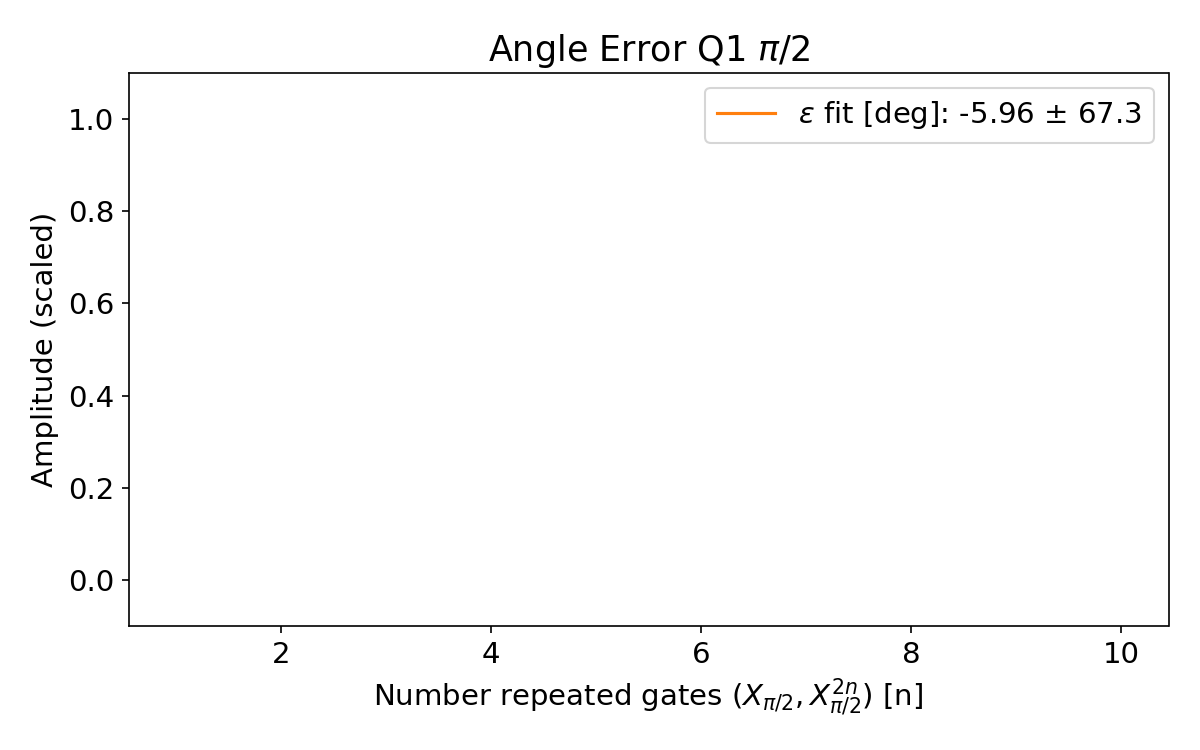

From avgi: adjust amplitude to 4982 / 1.005040158114645 = 4957.015856307408
From avgq: adjust amplitude to 4982 / 1.0662718218907257 = 4672.354551361827


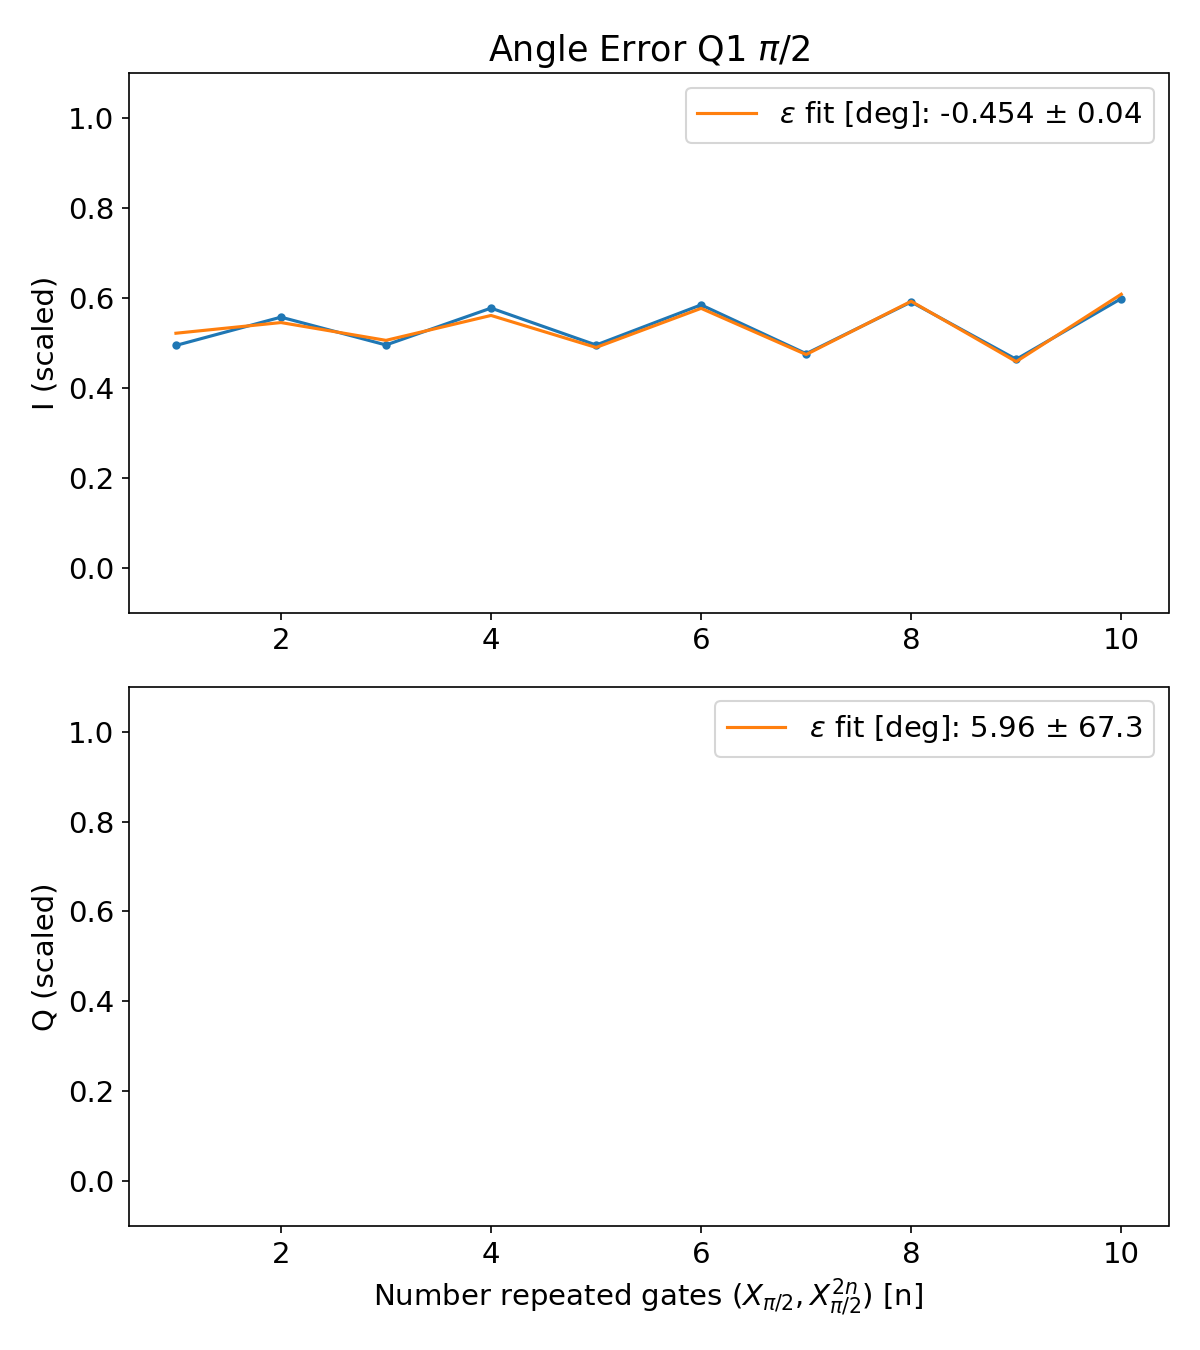

In [49]:
data = npulsecalib.data
npulsecalib.analyze(fit=True, scale=None)
npulsecalib.display(fit=True, scale=None)

# Test with 1Q tomo

In [ ]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence
from TomoAnalysis import TomoAnalysis
tomo_analysis = TomoAnalysis(nb_qubits=1)
import qutip as qt

meas_order = np.array(['Z', 'X', 'Y'])
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi_dict = dict(Z=psiZ, X=psiX, Y=psiY)

In [ ]:
qubit = 1 # which qubit/resonators to do tomo on
# init_state = '|1>|0+1>' # switch, input
# init_state = '|test>'
init_state = 'Q0Q1_|0>|0+1>'
# play_pulses = [2, 4] # [1, 3] # [2, 4] # [2, 1, 4, 3]
# play_pulses = [1, 3] # [1, 3] # [2, 4] # [2, 1, 4, 3]
# play_pulses = [1]*8 # Q2/Q1
# play_pulses = [2, 1, 4, 3]
play_pulses = [0]

pi_half_swaps = None
# pi_half_swaps = [True, False]

# cool_qubits = [0, 1]
cool_qubits = None
add_phase = False
readout_cool = False
use_IQ_pulse = False
use_robust_pulses = True # use robust pulses for state prep + tomo

# ZZ_qubit = 0
ZZ_qubit = None

print('play_pulses', play_pulses)

apply_ps = False
# ps_adjust = [-0.3, -1.0, -0.3, -0.3]
ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

psi_id = (psiZ[0]+psiZ[1]).unit()
# psi_id = psiZ[0].unit()

rho_id = qt.ket2dm(psi_id)
print(rho_id)

In [ ]:
# saved_files = []
qramExpt = meas.QramProtocol1QTomoExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

span = np.inf
npts = 1
if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))

qramExpt.cfg.expt = dict(
    # start=0, # start protocol time [us],
    # step=span/npts, # time step [us], 
    # expts=npts+1, # number of different time experiments - added 1 to include 0 step and full span

    start=span,
    step=0,
    expts=1, # number of different time experiments

    reps=2000, # number of reps per tomo/time step,
    # reps=20000, # number of reps per tomo/time step,
    # reps=2000000, # number of reps per tomo/time step,
    # singleshot_reps=1, # reps per state for singleshot calibration
    # singleshot_reps=20000, # reps per state for singleshot calibration
    singleshot_reps=10000, # reps per state for singleshot calibration
    # singleshot_reps=200, # reps per state for singleshot calibration
    post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
    qubit=qubit,
    init_state=init_state,
    play_pulses=play_pulses,
    
    cool_qubits=cool_qubits,
    
    use_IQ_pulse=use_IQ_pulse, # state transfer IQ pulses for the state prep
    use_robust_pulses=use_robust_pulses, # use robust pulses for state prep + tomo
    plot_IQ=False,
    
    add_phase=add_phase,
    ZZ_qubit=ZZ_qubit,
    pi_half_swaps=pi_half_swaps,
    
    # readout_cool=readout_cool,
    # n_init_readout=1,
    # n_trig=1,
    # # init_read_wait_us=5,
    # init_read_wait_us=10,
    
    
#     thresholds=[0, 435.2742847736969, 0, 0],
#     angles=[0, -71.14156770965094, 0, 0],
#     ge_avgs=[[0, 0, 0, 0], [-21.004029603255344, 340.8385202238047, 108.85149118006103, 532.2538750050865], [0, 0, 0, 0], [0, 0, 0, 0]] ,
#     counts_calib=[[17573.0, 2427.0], [3659.0, 16341.0]]
    
)

In [ ]:
tomo = qramExpt

In [ ]:
data = tomo.data
cfg = tomo.cfg
init_state = tomo.cfg.expt.init_state
qubit = tomo.cfg.expt.qubit
pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == tomo_analysis.meas_order)

print('meas_order', meas_order)

n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data=data, cfg=cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, tomo_qubits=[qubit], apply_ps=apply_ps, verbose=True)

print('Tomography counts')
for r in range(n_tomo_raw.shape[0]):
    n_tomo_raw[r,:]/=np.sum(n_tomo_raw[r,:])
print(n_tomo_raw)
print('Confusion matrix counts')
for r in range(n_calib.shape[0]):
    n_calib[r,:]/=np.sum(n_calib[r,:])
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(np.around(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib), decimals=5))
# print('Negative counts corrected tomo matrix will be')
# print(tomo_analysis.fix_neg_counts(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib)))

In [ ]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
rho_MLE = tomo_analysis.get_rho_from_counts(
    n_tomo_raw=n_tomo_raw,
    n_calib=n_calib,
    correct_readout=True,
    correct_neg_counts=True,
    method='analytical',
    ZZ_correction=False,
)

if rho_MLE is not None:
    fid_base = qt.fidelity(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_base = np.real(np.trace(rho_MLE @ rho_MLE))
    print(f'Fidelity (no ZZ correction): {fid_base}')
    print(f'Purity (no ZZ correction): {purity_base}')
print(np.around(rho_MLE, decimals=3))
savetitle=None
# savetitle=saved_files[-1][:-3]+f'_baseMLE_Q{qubit}.svg'
tomo_analysis.show_plot_rho_2d(rho_MLE, rho_id, title=f'Base MLE (Q{qubit}) Init {init_state}, Play {play_pulses}', cmax=0.5, savetitle=savetitle)

print('Saved svg:', savetitle)
print('Saved data:')
print(*saved_files)

## run the 2Q tomo

In [ ]:
tomo_analysis = TomoAnalysis(nb_qubits=2)

In [ ]:
def name_to_state_2q(init_state): # in format |QA>|QB>
    Qa, Qb, _ = init_state.split('>')
    Qa = Qa[1:]
    Qb = Qb[1:]
    psi_name_dict = {
        '0':psiZ[0],
        '1':psiZ[1],
        '0+1':(psiZ[0]+psiZ[1]).unit(),
        '0-1':(psiZ[0]-psiZ[1]).unit(), 
        '0+i1':(psiZ[0]+1j*psiZ[1]).unit(), 
        '0-i1':(psiZ[0]-1j*psiZ[1]).unit(), 
    }
    try:
        psiA = psi_name_dict[Qa]
    except:
        print(f'QA state {Qa} is not an allowed cardinal state')
    try:
        psiB = psi_name_dict[Qb]
    except:
        print(f'QB state {Qb} is not an allowed cardinal state')
    return qt.tensor(psiA, psiB)

    
psi_basis_3q = dict() # 27*8 elements
# psi_tensor = [psiZ[0], psiZ[0], psiZ[0], psiZ[0]]
S123 = 'ZZZ'
S1, S2, S3 = S123
psi1 = psi_dict[S1]
psi2 = psi_dict[S2]
psi3 = psi_dict[S3]

psi_basis_3q.update({S123:[]})

for state1 in (0,1):
    for state2 in (0,1):
        for state3 in (0,1):
            psi_basis_3q[S123].append(qt.tensor(psi1[state1], psi2[state2], psi3[state3]).unit())
calib_order_numeric_3q = ['000', '001', '010', '011', '100', '101', '110', '111']
psis = dict() # psis in the ZZZ basis
for i, label_numeric in enumerate(calib_order_numeric_3q):
    psis.update({label_numeric:psi_basis_3q['ZZZ'][i]})
id3q = qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2))

def get_qram_qSLR_state_from_rho(init_rho_IS, output_qubits, post_select=False, post_select_state=None):
    """
    init_rho_IS should be a np array
    outputs partial trace of qram output (needs output_qubits to all be in 0, 2, and/or 3 to work)
    """
    # in order |00>, |01>, |10>, |11> for switch, input
    SI_to_SLR = [psis['000'], -1j*psis['010'], psis['100'], -1j*psis['101']]

    assert np.all([q in [0, 2, 3] for q in output_qubits])
    assert np.shape(init_rho_IS) == id2q.shape
    rho_final_SLR = 0*qt.ket2dm(psis['000'])
    print(f'constructing final state on |Q{output_qubits[0]}, Q{output_qubits[1]}>')
    for i in range(len(SI_to_SLR)):
        slr_ket_i = SI_to_SLR[i]
        for j in range(len(SI_to_SLR)):
            slr_ket_j = SI_to_SLR[j]
            mat_el = init_rho_IS[i, j]
            rho_final_SLR += mat_el * slr_ket_i * slr_ket_j.dag()
    output_indices = [[0,2,3].index(q) for q in output_qubits]
    return qt.ptrace(rho_final_SLR.unit(), output_indices)

In [ ]:
tomo_qubits = [0, 1] # which qubit/resonators to do tomo on

init_state = '|0+1>|1>' # Q0/Q1 (switch, input)
# init_state = 'Q3Q0_|1>|1>'
# init_state = '|1>|0>' # Q0/Q1 (switch, input)
# init_state = 'Q2Q0_|1>|0>'
# init_state = '|1>|1>' # Q0/Q1 (switch, input)
# play_pulses = [2, 1, 4, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [2, 4] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [1, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
play_pulses = [0] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [2]*8 # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]

# cool_qubits = [0, 1]
cool_qubits = None


readout_cool = False

use_IQ_pulse = False # state transfer IQ pulses for the state prep
use_robust_pulses = True # use robust pulses for state prep + tomo

post_select = False # this is not the readout post selection

# add_phase = True # phase for swaps
add_phase = False
print('init_state', init_state)
print('post select', post_select)
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]
use_ZZ_mat = True

rho_id = qt.ket2dm(name_to_state_2q(init_state))

evol_mats_path = "S:\\QRAM\\qram_4QR2\\evol_mats"
print('Will save evol mats to path', evol_mats_path)

q0, q1 = tomo_qubits
evol_mats_filename = f'evol_mats_{q0}{q1}.npz'


In [ ]:
run_evol = False 

if run_evol:
    evol_mats = tomo_analysis.get_evol_mats_from_yaml(
        tomo_qubits=tomo_qubits,
        yaml_cfg=yaml_cfg,
        pulse_dict=pulse_dict,
        cutoffs=[4]*(len(tomo_qubits)),
        soccfg=soc,
        debug=True,
        evol_mats_path=evol_mats_path,
        evol_mats_filename=evol_mats_filename,
    )
else:
    evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
    print(f'Using evol mats from file {evol_mats_file_path}')

    evol_mats = dict()
    with np.load(evol_mats_file_path) as npzfile:
        for key in npzfile.keys():
            evol_mats.update({key:npzfile[key]})

In [ ]:
qramExpt = meas.QramProtocolExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,)


qramExpt.cfg.expt = dict(
        # start=0, # start protocol time [us],
        # step=span/npts, # time step [us], 
        # expts=npts+1, # number of different time experiments - added 1 to include 0 step and full span

        start=span,
        step=0,
        expts=1, # number of different time experiments

        reps=10000, # number of reps per time step,
        # singleshot_reps=100, # reps per state for singleshot calibration
        singleshot_reps=10000, # reps per state for singleshot calibration
        post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        tomo_2q=True, # True/False whether to do 2q state tomography on state at last time step
        tomo_qubits=tomo_qubits, # the qubits on which to do the 2q state tomo
        calib_apply_q1_pi2=False, # initialize Q1 to 0+1 for all calibrations
        init_state=init_state,
        play_pulses=play_pulses,
        cool_qubits=cool_qubits,
        
        use_IQ_pulse=use_IQ_pulse, # state transfer IQ pulses for the state prep
        use_robust_pulses=use_robust_pulses, # use robust pulses for state prep + tomo
        plot_IQ=True,
        
        add_phase=add_phase,
        
        # readout_cool=readout_cool,
        # n_init_readout=1,
        # n_trig=1,
        # # init_read_wait_us=5,
        # init_read_wait_us=10,
        
        # Icontrols=I_values_MHz, # 2D array with array of Icontrols for each of IQ_qubits
        # Qcontrols=Q_values_MHz, # 2D array with array of Qcontrols for each of IQ_qubits
        # times_us=times_us,
        # IQ_qubits=IQ_qubits,
        # IQ_gain=[3700, 3950],
        
        # thresholds=[33.169103683345895, 37.49913270024612, 0, 0],
        # angles=[-24.579056838557847, 115.19639444481155, 0, 0],
        # ge_avgs=[[34.43056101813111, -9.525004532775455, 44.589988819153874, -4.651175313807532], [30.053312459336368, -50.17723301886793, 25.548312166558233, -59.65660634352635], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
        # counts_calib=[[12553, 5207, 1604, 636], [4673, 12956, 666, 1705], [2241, 876, 12383, 4500], [918, 2095, 4712, 12275]]
 
    )

    # print(qramExpt.cfg)

import Pyro4.util
try:
    qramExpt.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
cfg = qramExpt.cfg
print('init state', qramExpt.cfg.expt.init_state)


tomo = qramExpt
data = tomo.data

n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)
    
rho_MLE_ZZ = tomo_analysis.get_rho_from_counts(
        n_tomo_raw=n_tomo_raw,
        n_calib=n_calib,
        correct_readout=True,
        correct_neg_counts=True,
        method='analytical',
        ZZ_correction=use_ZZ_mat,
        evol_mats=evol_mats
    )

print(np.around(rho_MLE_ZZ, decimals=3))
print('list format', np.around(rho_MLE_ZZ, decimals=3).tolist())
fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (with ZZ correction): {fid_ZZ}')
print(f'Purity (with ZZ correction): {purity_ZZ}')
print(f'Target purity: {purity_id}')